In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet101
from keras.layers import Conv2D, BatchNormalization, UpSampling2D, Concatenate, Input, LeakyReLU, Dropout, Softmax, Activation, MaxPool2D, Conv2DTranspose
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)

    return x,p

In [ ]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s3, 64)

    outputs = Conv2D(num_classes, 1, padding='same', activation="softmax")(d4)
    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = (256,256,3)
model = build_unet(input_shape, num_classes=NUM_CLASSES)
model.summary()

In [14]:
def normalize_image(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [15]:
def normalize_mask(input_mask):
    input_mask -= 1
    return input_mask

In [16]:
def images(image):
    input_image = tf.image.resize(image, (128, 128))
    input_image = normalize_image(input_image)
    return input_image

In [17]:
def masks(mask):
    input_mask = tf.image.resize(mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = normalize_mask(input_mask)
    return input_mask

In [18]:
train = keras.utils.image_dataset_from_directory(directory='dataset/images/train', label_mode=None, labels=None,
                                                 shuffle=False)
train_mask = keras.utils.image_dataset_from_directory(directory='dataset/annotations/train', label_mode=None,
                                                      labels=None, shuffle=False)
test = keras.utils.image_dataset_from_directory(directory='dataset/images/val', label_mode=None, labels=None,
                                                shuffle=False)
test_mask = keras.utils.image_dataset_from_directory(directory='dataset/annotations/val', label_mode=None, labels=None,
                                                     shuffle=False)

Found 118287 files belonging to 1 classes.
Found 118287 files belonging to 1 classes.
Found 5000 files belonging to 1 classes.
Found 5000 files belonging to 1 classes.


In [19]:
train_images = train.map(images, num_parallel_calls=tf.data.AUTOTUNE)
train_masks = train_mask.map(masks, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test.map(images, num_parallel_calls=tf.data.AUTOTUNE)
test_masks = test_mask.map(masks, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

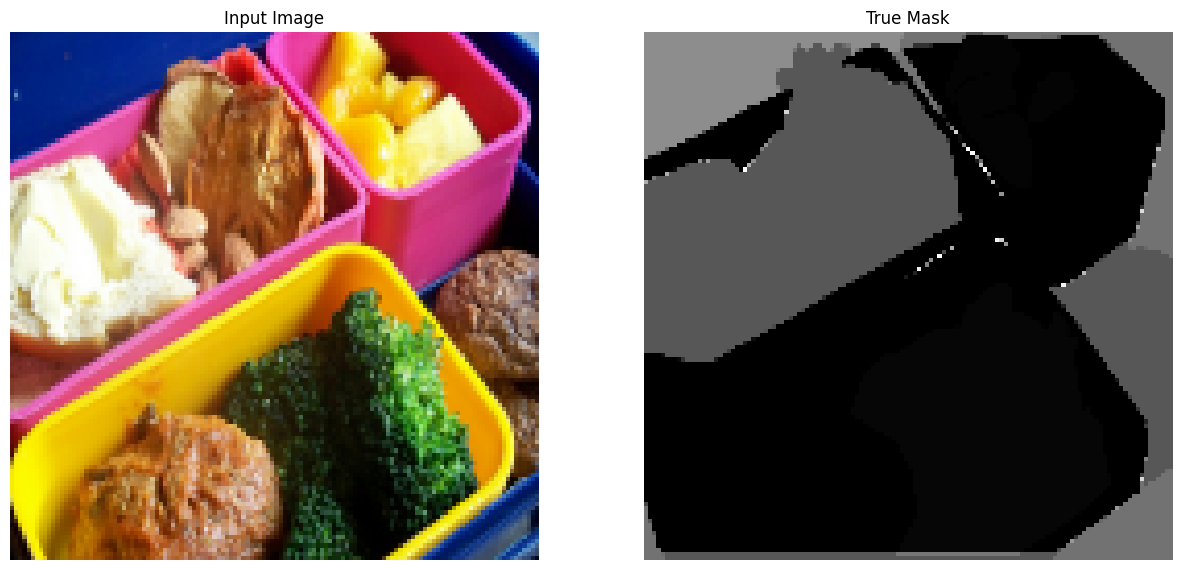

In [21]:
for image, mask in zip(train_images, train_masks):
    break
sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

In [22]:
def resnet101_unet(input_shape, *, classes, dropout):
    """ Input """
    inputs = Input(input_shape, name="Input_1")

    resnet101 = ResNet101(include_top=False, weights="imagenet", input_tensor=inputs)

    def decoder_block(x, y, filters):
        x = UpSampling2D()(x)
        x = Concatenate(axis = 3)([x,y])
        x = Conv2D(filters, 3, padding= 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters, 3, padding= 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        return x


    """ Encoder """
    s1 = resnet101.get_layer("Input_1").output
    s2 = resnet101.get_layer("conv1_relu").output
    s3 = resnet101.get_layer("conv2_block3_out").output
    s4 = resnet101.get_layer("conv3_block4_out").output
    s5 = resnet101.get_layer("conv4_block6_out").output
    x = resnet101.get_layer("conv5_block3_out").output

    """ Decoder """
    x = decoder_block(x, s5, 1024)
    x = decoder_block(x, s4, 512)
    x = decoder_block(x, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    x = Dropout(dropout)(x)
    x = Conv2D(classes, 1)(x)
    outputs = Softmax()(x)

    model = Model(inputs, outputs, name="ResNet101_U-Net")
    return model



In [23]:
train_ds = tf.data.Dataset.zip((train_images,train_masks))
val_ds = tf.data.Dataset.zip((test_images, test_masks))

In [25]:
model = resnet101_unet((128, 128, 3), classes= 204, dropout= 0.2)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 88cf7a10940856eca736dc7b7e228a21 so we will re-download the data.
169730048/171446536 [============================>.] - ETA: 1s

ValueError: Incomplete or corrupted file detected. The auto file hash does not match the provided value of 88cf7a10940856eca736dc7b7e228a21.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("resnet101_chkp\\save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=2.5e-3),
    loss=keras.metrics.MeanIoU(204),
    metrics=['accuracy'],
)
model.fit(train_ds, batch_size=1,
          epochs=64,
          callbacks=callbacks,
          validation_data=val_ds,
          )
